
### stacked map of galaxy pairs from pair catalog


Stacking pairs:   0%|          | 1789/1465997 [00:00<11:41, 2087.26it/s]

1380: Theta less than zero encountered: -0.007014819132025954


Stacking pairs:   1%|▏         | 18654/1465997 [00:08<10:19, 2335.36it/s]

18331: Theta less than zero encountered: -0.024710955487568822


Stacking pairs:   1%|▏         | 20058/1465997 [00:09<10:23, 2319.17it/s]

19799: Theta less than zero encountered: -0.03143178904598009


Stacking pairs:   2%|▏         | 27120/1465997 [00:12<10:38, 2254.31it/s]

26712: Theta less than zero encountered: -0.0005221829829004156


Stacking pairs:   2%|▏         | 29003/1465997 [00:13<10:08, 2362.95it/s]

28583: Theta less than zero encountered: -0.003347620567894698


Stacking pairs:   2%|▏         | 29476/1465997 [00:13<10:16, 2331.56it/s]

29087: Theta less than zero encountered: -0.025815730054075288
29493: Theta less than zero encountered: -0.0065325388270839274


Stacking pairs:   2%|▏         | 29944/1465997 [00:13<10:17, 2326.44it/s]

29626: Theta less than zero encountered: -0.009528978761352723
29968: Theta less than zero encountered: -0.027242401880363684


Stacking pairs:   2%|▏         | 32314/1465997 [00:14<10:04, 2371.43it/s]

31902: Theta less than zero encountered: -0.0029444571113180747


Stacking pairs:   2%|▏         | 33260/1465997 [00:14<10:13, 2335.36it/s]

33014: Theta less than zero encountered: -0.0074866174243414


Stacking pairs:   2%|▏         | 36107/1465997 [00:16<10:02, 2373.72it/s]

35716: Theta less than zero encountered: -0.003370296789958304


Stacking pairs:   3%|▎         | 39681/1465997 [00:17<10:00, 2375.00it/s]

39328: Theta less than zero encountered: -0.024870122218705427


Stacking pairs:   3%|▎         | 46137/1465997 [00:20<09:55, 2383.24it/s]

45656: Theta less than zero encountered: -0.020237850641454107
45657: Theta less than zero encountered: -0.020164630121562506
45951: Theta less than zero encountered: -0.022267163954789504


Stacking pairs:   4%|▍         | 57279/1465997 [00:25<09:50, 2384.67it/s]

56939: Theta less than zero encountered: -0.0035553240038805767
56940: Theta less than zero encountered: -0.0035431886047362416


Stacking pairs:   5%|▌         | 73997/1465997 [00:32<13:14, 1751.15it/s]

73785: Theta less than zero encountered: -0.009079099035133731


Stacking pairs:   7%|▋         | 95988/1465997 [00:43<09:49, 2325.17it/s]

95710: Theta less than zero encountered: -0.0005313595125293414


Stacking pairs:   7%|▋         | 97139/1465997 [00:43<10:04, 2266.17it/s]

96684: Theta less than zero encountered: -0.0004194980264299002


Stacking pairs:   7%|▋         | 97822/1465997 [00:44<10:46, 2116.53it/s]

97478: Theta less than zero encountered: -0.015813174709152108


Stacking pairs:   7%|▋         | 99209/1465997 [00:44<09:54, 2298.37it/s]

98916: Theta less than zero encountered: -0.0009518948098616706
98917: Theta less than zero encountered: -0.0015387744456830015


Stacking pairs:  12%|█▏        | 169931/1465997 [01:15<09:59, 2163.13it/s]

169511: Theta less than zero encountered: -0.018071161172462758


Stacking pairs:  18%|█▊        | 258254/1465997 [01:52<08:11, 2458.86it/s]

257848: Theta less than zero encountered: -9.545121677874158e-05


Stacking pairs:  18%|█▊        | 261424/1465997 [01:54<08:21, 2400.75it/s]

261114: Theta less than zero encountered: -0.0013750492302661871


Stacking pairs:  19%|█▉        | 275526/1465997 [02:00<08:08, 2434.58it/s]

275073: Theta less than zero encountered: -0.0170341240876689
275074: Theta less than zero encountered: -0.01591433057052268


Stacking pairs:  20%|██        | 294204/1465997 [02:08<08:02, 2430.90it/s]

293950: Theta less than zero encountered: -0.0025810232879355318


Stacking pairs:  24%|██▍       | 350782/1465997 [02:33<08:00, 2321.64it/s]

350522: Theta less than zero encountered: -0.013258836907517495


Stacking pairs:  25%|██▍       | 360526/1465997 [02:37<07:57, 2315.05it/s]

360146: Theta less than zero encountered: -0.0010053371756595481


Stacking pairs:  25%|██▍       | 364316/1465997 [02:39<07:49, 2346.45it/s]

364050: Theta less than zero encountered: -0.002683982052339273


Stacking pairs:  26%|██▌       | 379787/1465997 [02:46<07:47, 2324.67it/s]

379430: Theta less than zero encountered: -0.014582926168383362


Stacking pairs:  26%|██▌       | 381621/1465997 [02:47<08:02, 2248.11it/s]

381206: Theta less than zero encountered: -0.01678235827000365


Stacking pairs:  26%|██▋       | 385375/1465997 [02:48<07:51, 2289.70it/s]

384928: Theta less than zero encountered: -0.009566670086401767


Stacking pairs:  26%|██▋       | 386749/1465997 [02:49<07:56, 2266.70it/s]

386407: Theta less than zero encountered: -0.0047146176159263056


Stacking pairs:  26%|██▋       | 387689/1465997 [02:49<07:42, 2330.09it/s]

387268: Theta less than zero encountered: -0.015706876021490252


Stacking pairs:  27%|██▋       | 393283/1465997 [02:52<08:07, 2199.89it/s]

392856: Theta less than zero encountered: -0.01451266162974996


Stacking pairs:  27%|██▋       | 393726/1465997 [02:52<08:10, 2184.83it/s]

393433: Theta less than zero encountered: -0.00042687880874708563


Stacking pairs:  27%|██▋       | 401728/1465997 [02:55<07:55, 2238.96it/s]

401482: Theta less than zero encountered: -0.0032041922689864423
401483: Theta less than zero encountered: -0.0019170250652336654


Stacking pairs:  28%|██▊       | 406448/1465997 [02:57<07:47, 2264.88it/s]

406190: Theta less than zero encountered: -0.01237020321024228


Stacking pairs:  28%|██▊       | 410915/1465997 [02:59<07:50, 2242.17it/s]

410551: Theta less than zero encountered: -0.014766437810717166


Stacking pairs:  29%|██▊       | 418570/1465997 [03:03<07:16, 2401.96it/s]

418313: Theta less than zero encountered: -0.010969654484924186


Stacking pairs:  29%|██▉       | 431534/1465997 [03:09<07:17, 2362.40it/s]

431065: Theta less than zero encountered: -0.004255708082631192


Stacking pairs:  30%|██▉       | 434163/1465997 [03:10<07:25, 2314.57it/s]

433764: Theta less than zero encountered: -0.01817225024476459


Stacking pairs:  30%|██▉       | 436498/1465997 [03:11<07:47, 2203.17it/s]

436167: Theta less than zero encountered: -0.0010352683983042492


Stacking pairs:  31%|███       | 447769/1465997 [03:16<07:01, 2416.81it/s]

447407: Theta less than zero encountered: -0.023728858382573523


Stacking pairs:  31%|███       | 453676/1465997 [03:18<07:24, 2278.96it/s]

453266: Theta less than zero encountered: -8.834241718085705e-05


Stacking pairs:  31%|███       | 454128/1465997 [03:18<07:38, 2207.81it/s]

453825: Theta less than zero encountered: -0.010327418470075173


Stacking pairs:  31%|███       | 455764/1465997 [03:19<07:13, 2328.60it/s]

455400: Theta less than zero encountered: -6.147313626755546e-06


Stacking pairs:  31%|███▏      | 459538/1465997 [03:21<07:22, 2274.39it/s]

459247: Theta less than zero encountered: -0.00048060456024346017


Stacking pairs:  32%|███▏      | 473420/1465997 [03:27<07:29, 2209.08it/s]

473090: Theta less than zero encountered: -0.004202864453628761
473091: Theta less than zero encountered: -0.00485385364552569


Stacking pairs:  33%|███▎      | 488731/1465997 [03:34<07:10, 2271.57it/s]

488462: Theta less than zero encountered: -0.004547790582901327


Stacking pairs:  34%|███▍      | 501349/1465997 [03:39<07:54, 2034.57it/s]

501020: Theta less than zero encountered: -0.007393038885663696


Stacking pairs:  39%|███▉      | 570027/1465997 [04:09<06:39, 2242.63it/s]

569595: Theta less than zero encountered: -0.0009930577746791612


Stacking pairs:  44%|████▍     | 648966/1465997 [04:44<06:17, 2164.84it/s]

648625: Theta less than zero encountered: -0.003085922599654148


Stacking pairs:  47%|████▋     | 689269/1465997 [05:02<05:45, 2245.25it/s]

688826: Theta less than zero encountered: -0.006830888449968615


Stacking pairs:  47%|████▋     | 694475/1465997 [05:04<05:46, 2225.30it/s]

694101: Theta less than zero encountered: -0.005816591947250814
694102: Theta less than zero encountered: -0.005701281158816842


Stacking pairs:  47%|████▋     | 695587/1465997 [05:05<05:56, 2159.06it/s]

695363: Theta less than zero encountered: -0.004306174892822289
695364: Theta less than zero encountered: -0.0030451061462702495


Stacking pairs:  52%|█████▏    | 768571/1465997 [05:38<05:27, 2129.82it/s]

768257: Theta less than zero encountered: -0.004018595062340799


Stacking pairs:  54%|█████▎    | 786199/1465997 [05:46<05:20, 2118.22it/s]

785951: Theta less than zero encountered: -0.023968827595930813


Stacking pairs:  54%|█████▍    | 793996/1465997 [05:50<05:11, 2155.96it/s]

793691: Theta less than zero encountered: -0.024819018009668226


Stacking pairs:  62%|██████▏   | 915354/1465997 [06:46<04:22, 2097.54it/s]

915129: Theta less than zero encountered: -0.010349138645017214


Stacking pairs:  63%|██████▎   | 917986/1465997 [06:48<04:11, 2178.37it/s]

917743: Theta less than zero encountered: -0.0010600065804474929


Stacking pairs:  63%|██████▎   | 920460/1465997 [06:49<04:07, 2205.88it/s]

920069: Theta less than zero encountered: -0.005985052567933626
920070: Theta less than zero encountered: -0.004527099221433039


Stacking pairs:  63%|██████▎   | 926251/1465997 [06:51<04:04, 2207.10it/s]

925822: Theta less than zero encountered: -0.001790303142184996


Stacking pairs:  64%|██████▍   | 939502/1465997 [06:58<04:14, 2071.85it/s]

939253: Theta less than zero encountered: -0.008909103060899315


Stacking pairs:  65%|██████▌   | 959893/1465997 [07:07<03:50, 2198.16it/s]

959550: Theta less than zero encountered: -0.007162313876767901


Stacking pairs:  66%|██████▌   | 962226/1465997 [07:09<04:03, 2070.90it/s]

961878: Theta less than zero encountered: -0.007851019600040606


Stacking pairs:  66%|██████▌   | 963342/1465997 [07:09<03:47, 2208.00it/s]

962968: Theta less than zero encountered: -0.007035437013022523


Stacking pairs: 100%|██████████| 1465997/1465997 [11:12<00:00, 2179.90it/s]


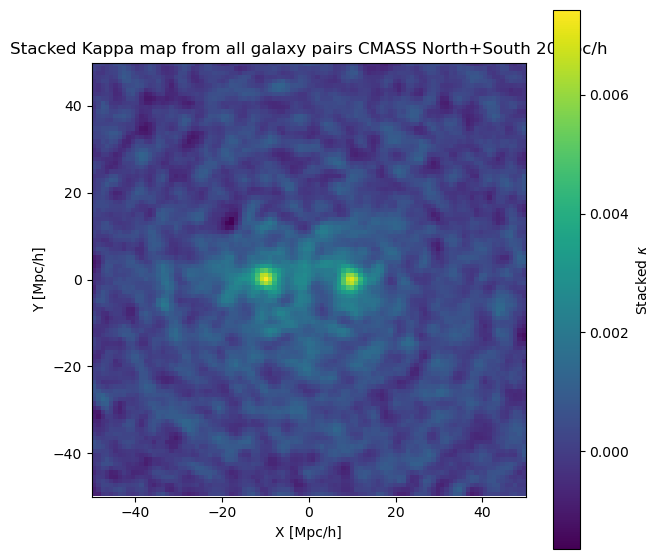

In [24]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

# --- Load catalog and map as before ---
# pairs = pd.read_csv('data/galaxy_pairs_catalog_5hmpc.csv')

# --- Settings ---
distance = 20
dataset = "BOSS"
if dataset == "eBOSS":
    pairs_NGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_{distance}hmpc.csv')
    pairs_SGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_SGC_{distance}hmpc.csv')
    pairs = pd.concat([pairs_NGC, pairs_SGC], ignore_index=True)
elif dataset == "BOSS":
    catalog, region = "CMASS", "North+South"
    pairs_NGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_CMASS_North_{distance}_{distance-2}_{distance+2}hmpc.csv')
    pairs_SGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_CMASS_South_{distance}_{distance-2}_{distance+2}hmpc.csv')
    pairs = pd.concat([pairs_NGC, pairs_SGC], ignore_index=True)
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"
nside = 2048

alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=np.radians(8/60)), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Grid parameters ---
grid_size = 100.0 # Mpc/h box size
grid_res = 101
half_size = grid_size / 2
X_vals = np.linspace(-half_size, half_size, grid_res)
Y_vals = np.linspace(-half_size, half_size, grid_res)
X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)

# Initialize stack accumulators
kappa_stack_sum = np.zeros((grid_res, grid_res))
weight_stack_sum = np.zeros((grid_res, grid_res))

# Loop over all pairs
for idx, pair in tqdm(pairs.iterrows(), total=len(pairs), desc="Stacking pairs"):
    # Extract pair data (convert to radians)
    l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
    l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']

    # --- Enforce consistent ordering of longitudes ---
    # Compute raw difference, wrapped into [-π, π]
    dl_raw = (l2 - l1 + np.pi) % (2*np.pi) - np.pi

    # If "l2 is to the left of l1", swap them
    if dl_raw < 0:
        l1, l2 = l2, l1
        b1, b2 = b2, b1
        z1, z2 = z2, z1
        dl_raw = -dl_raw   # now positive

    # --- Midpoint (wrap-safe) ---
    lc = l1 + 0.5 * dl_raw
    bc = 0.5 * (b1 + b2)
    zbar = 0.5 * (z1 + z2)
    Dc = cosmo.comoving_distance(zbar).value * cosmo.h  # Mpc/h

    # --- Rotation angle θ ---
    dl = dl_raw * np.cos(bc)
    db = (b2 - b1)
    norm = np.hypot(dl, db)
    cos_theta, sin_theta = dl / norm, db / norm

    # Inverse transform (X,Y) -> (l,b)
    dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
    db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
    l_grid = lc + dl_cosbc / np.cos(bc)
    b_grid = bc + db_grid

    # Convert to degrees
    l_grid_deg = np.rad2deg(l_grid)
    b_grid_deg = np.rad2deg(b_grid)

    # Convert to Healpix pixels
    l_grid_deg_wrapped = np.mod(l_grid_deg, 360)
    theta = np.radians(90 - b_grid_deg)
    if np.min(theta) < 0:
        print(f"{idx}: Theta less than zero encountered: {np.min(theta)}")
        continue
    if np.max(theta) > np.pi:
        print(f"{idx}: Theta greater than zero encountered: {np.max(theta)}")
        continue
    phi = np.radians(l_grid_deg_wrapped)
    # theta = np.clip(theta, 0, np.pi)  # Ensure valid range
    pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())

    # Sample kappa and mask
    kappa_vals = kmap[pix].reshape(grid_res, grid_res)
    mask_vals = mask[pix].reshape(grid_res, grid_res)

    # Mask out invalid pixels
    valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
    kappa_vals[~valid_mask] = 0.0

    # Weights: if you have pair weights, use them here
    weight = 1.0  # equal weighting for now

    # Accumulate weighted sum and weights
    kappa_stack_sum += weight * kappa_vals
    weight_stack_sum += weight * valid_mask.astype(float)

# Avoid division by zero
nonzero = weight_stack_sum > 0
kappa_stack_mean = np.zeros_like(kappa_stack_sum)
kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]

# Plot stacked map
plt.figure(figsize=(7,7))
extent = [-half_size, half_size, -half_size, half_size]
im = plt.imshow(kappa_stack_mean, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title(f'Stacked Kappa map from all galaxy pairs {catalog} {region} {distance}Mpc/h')
plt.show()

In [25]:
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack_mean)

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


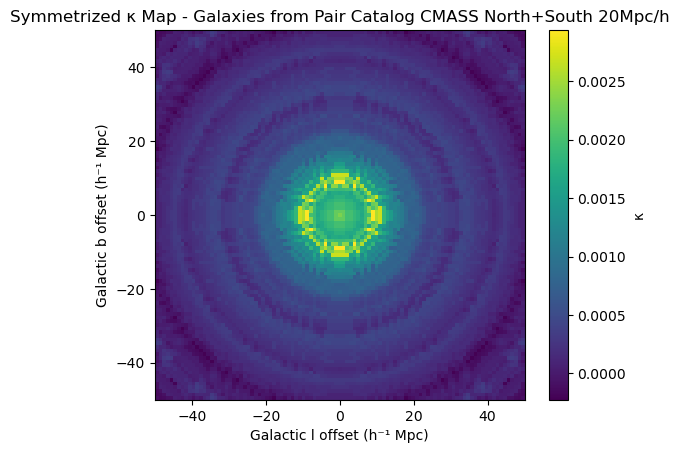

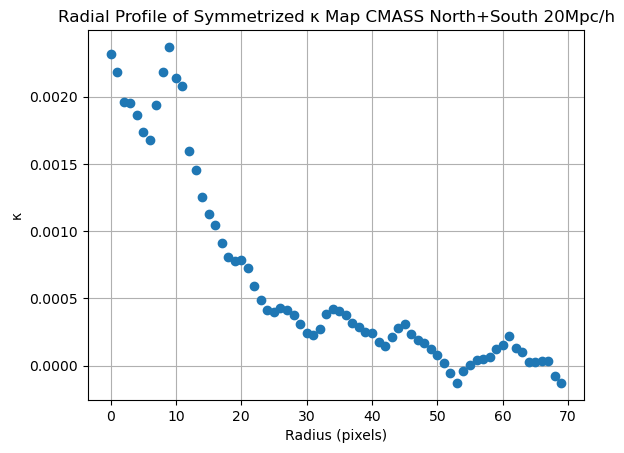

(array([ 2.31920762e-03,  2.18582672e-03,  1.95930522e-03,  1.95145584e-03,
         1.86637163e-03,  1.73943252e-03,  1.67772117e-03,  1.94228067e-03,
         2.18791064e-03,  2.37084060e-03,  2.13595468e-03,  2.08305203e-03,
         1.59538032e-03,  1.45812239e-03,  1.25513412e-03,  1.12799844e-03,
         1.04410517e-03,  9.15281313e-04,  8.11235803e-04,  7.79061770e-04,
         7.82178038e-04,  7.29223532e-04,  5.96107981e-04,  4.88281625e-04,
         4.12541761e-04,  4.00978745e-04,  4.28508117e-04,  4.13726267e-04,
         3.79907725e-04,  3.06915161e-04,  2.40061725e-04,  2.28722122e-04,
         2.71911107e-04,  3.87505113e-04,  4.22891246e-04,  4.07110782e-04,
         3.76048671e-04,  3.15750777e-04,  2.89482751e-04,  2.53831938e-04,
         2.39944492e-04,  1.77453040e-04,  1.47710017e-04,  2.15359614e-04,
         2.78318404e-04,  3.08238618e-04,  2.36609140e-04,  1.90501111e-04,
         1.67240234e-04,  1.27290710e-04,  7.58982690e-05,  1.79081870e-05,
        -5.6

In [26]:
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title=f"Radial Profile of Symmetrized κ Map {catalog} {region} {distance}Mpc/h", zoom=70)

In [27]:
# The next section explores reflection symmetry enforcement
# The next graph is the one that I attached to the google doc

In [28]:
def reflect_symmetrize_map(kappa_map):
    """
    Apply reflection symmetry: for every (x,y), average values at
    (+/-x, +/-y) and assign the average to all four.
    Assumes kappa_map is square with odd dimensions (so center is defined).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2  # integer index of the center pixel

    for i in range(center + 1):       # only need to loop half
        for j in range(center + 1):
            # Offsets from the center
            di, dj = i - center, j - center

            # Four symmetric positions
            coords = [
                (center + di, center + dj),
                (center - di, center + dj),
                (center + di, center - dj),
                (center - di, center - dj),
            ]

            # Extract values
            vals = [kappa_map[x, y] for x, y in coords]

            # Compute mean
            avg_val = np.mean(vals)

            # Assign average back
            for x, y in coords:
                sym_map[x, y] = avg_val

    return sym_map

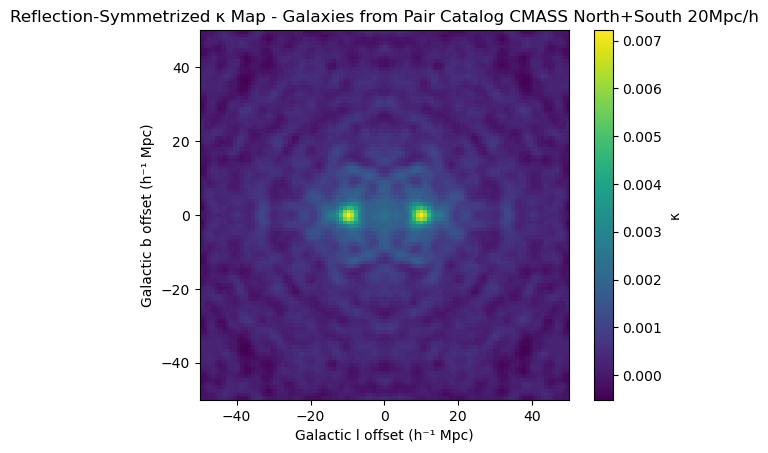

In [29]:
# --- Plot symmetrized map (reflection symmetry) ---
kappa_sym = reflect_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

In [30]:
pd.DataFrame(kappa_sym).to_csv(fr"data/kappa_sym_{distance}_NGCSGC.csv", index=True)

In [31]:
def reflect_x_symmetrize_map(kappa_map):
    """
    Enforce reflection symmetry only across the Y axis:
    average (+x,y) and (-x,y).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2

    for i in range(center + 1):
        for j in range(n):
            di = i - center
            coords = [
                (center + di, j),
                (center - di, j),
            ]
            vals = [kappa_map[x, y] for x, y in coords]
            avg_val = np.mean(vals)
            for x, y in coords:
                sym_map[x, y] = avg_val
    return sym_map

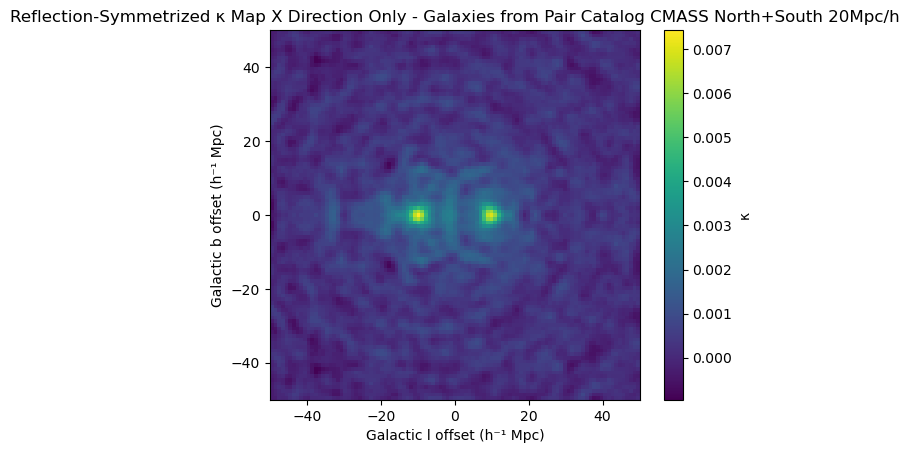

In [32]:
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map X Direction Only - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

In [33]:
def reflect_x_symmetrize_map(kappa):
    """
    Enforce reflection symmetry across the Y axis (left/right):
    average (+x, y) with (-x, y). Works for odd-sized square maps.
    """
    h, w = kappa.shape
    assert h == w and (w % 2 == 1), "Map must be square with odd dim."
    c = w // 2  # center column

    sym = kappa.copy()

    # Left half incl. center vs right half reversed (for column mirror)
    left  = kappa[:, :c+1]           # columns [0..c]
    right = np.fliplr(kappa)[:, :c+1]  # mirror of columns [c..end]

    avg = 0.5 * (left + right)

    # Put averaged half back, then mirror it to the other side
    sym[:, :c+1] = avg
    sym[:, c:]   = np.fliplr(avg)
    return sym

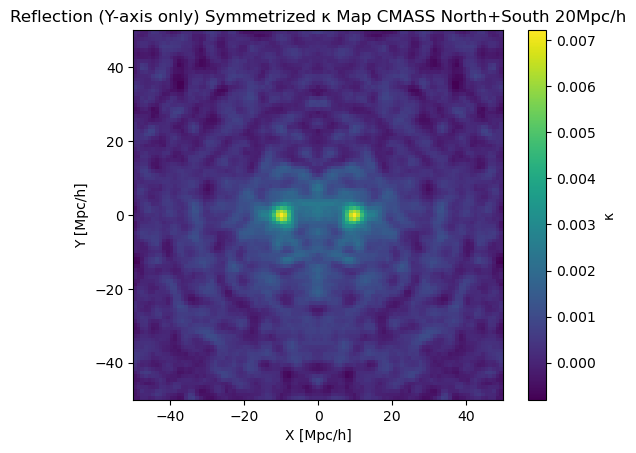

In [34]:
# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("X [Mpc/h]"); plt.ylabel("Y [Mpc/h]")
plt.title(f"Reflection (Y-axis only) Symmetrized κ Map {catalog} {region} {distance}Mpc/h")
plt.show()